In [ ]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join("..")))

In [ ]:
from src.models.ResNetVAE import VAELitModule

data_dir = "../data/FDP/"
runs = [
    "logs/train/multiruns/dims_and_lossfns/0",
    "logs/train/multiruns/dims_and_lossfns/2",
    "logs/train/multiruns/dims_and_lossfns/4",
    "logs/train/multiruns/dims_and_lossfns/6",
    "logs/train/multiruns/dims_and_lossfns/1",
    "logs/train/multiruns/dims_and_lossfns/3",
    "logs/train/multiruns/dims_and_lossfns/5",
    "logs/train/multiruns/dims_and_lossfns/7",
]
sample_size = 8
ICSD_codes = os.listdir(data_dir)
chosen_codes = np.random.choice(ICSD_codes, sample_size)

In [ ]:
runs_fakes = []
run_dims = []
run_lossfns = []

transform = transforms.ToTensor()
structures = torch.stack(
    [
        transform(
            np.load(
                os.path.join(data_dir, ICSD_code, ICSD_code + "_structure.npy")
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)
patterns = torch.stack(
    [
        transform(
            np.clip(
                np.load(os.path.join(data_dir, ICSD_code, ICSD_code + "_+0+0+0.npy")),
                0,
                1,
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)

for run in runs:
    litmodule = VAELitModule.load_from_checkpoint(
        f"D:\\felix-ml\\{run}\\checkpoints\\epoch_049.ckpt"  # Epoch 50
    )
    fakes = litmodule.model(structures.cuda())
    fakes = fakes.view(sample_size * 128, 128).detach().cpu().numpy()
    runs_fakes.append(fakes)
    with open(f"D:\\felix-ml\\{run}\\config_tree.log", "r") as f:
        for line in f:
            if "embed_dim" in line:
                embed_dim = line[line.find(":") + 1 : -1]
                run_dims.append(embed_dim.strip())
            if "src.models.util." in line:
                lossfn = line[line.find("src.models.util.") + 16 : -1]
                run_lossfns.append(lossfn.strip())

structures = structures.view(sample_size * 128, 128).detach().cpu().numpy()
patterns = patterns.view(sample_size * 128, 128).detach().cpu().numpy()

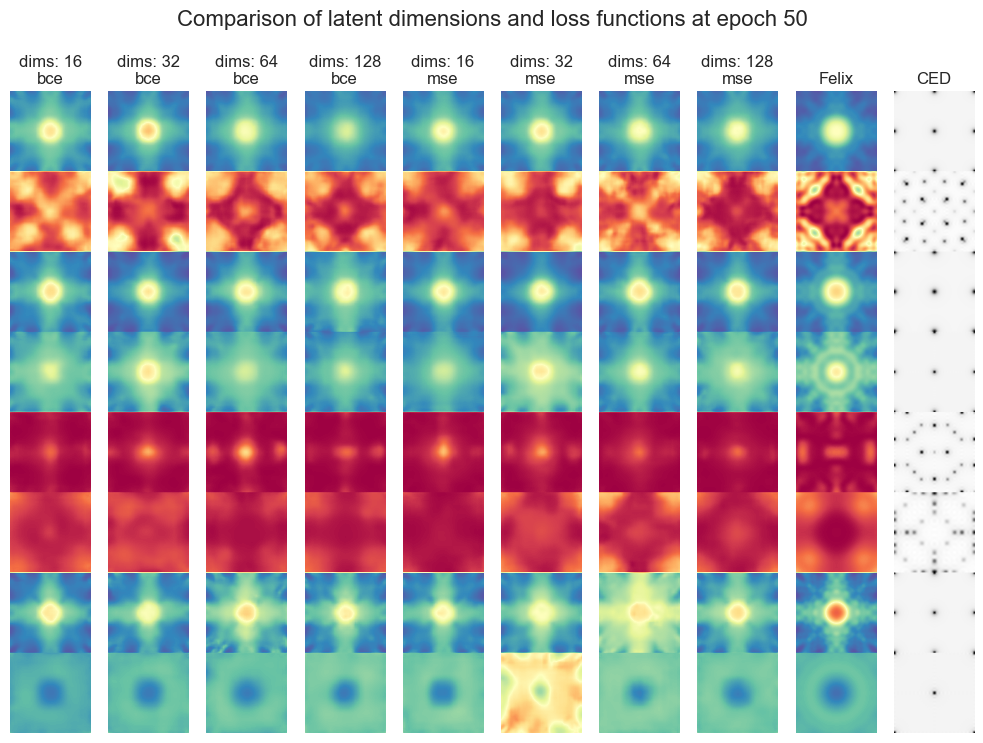

In [ ]:
import seaborn as sns

sns.set_theme()

fig, axs = plt.subplots(ncols=len(runs) + 2, figsize=(len(runs) + 2, sample_size))

fig.suptitle(
    "Comparison of latent dimensions and loss functions at epoch 50", fontsize=16
)

for i, run in enumerate(runs):
    im = axs[i].imshow(runs_fakes[i], cmap="Spectral")
    axs[i].set_title(f"dims: {run_dims[i]}\n{run_lossfns[i]}")

im1 = axs[-2].imshow(patterns, cmap="Spectral")
axs[-2].set_title("Felix")

im0 = axs[-1].imshow(structures, cmap="Greys")
axs[-1].set_title("CED")


for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()